# Simulate and optimize dynamics with the superconducting systems module
**Engineering and simulating gates in superconducting transmon-cavity systems**

In this tutorial you will simulate a realistic superconducting transmon, visualize the system's dynamics, and implement a basic quantum gate.
You will also carry out an optimization to achieve a leakage-free target state transfer process for a transmon coupled to an oscillator.

Through this tutorial you will get introduced to the [Boulder Opal superconducting functionality](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting.html) and visualize the results of the simulations and optimizations with the [Q-CTRL Visualizer package](https://docs.q-ctrl.com/references/qctrl-visualizer/).

## Simulating a transmon gate

Your task will be to simulate and visualize dynamics of a superconducting transmon.

In a frame rotating with the transmon frequency and assuming that the drive is resonant, the system can be described by the following Hamiltonian:

$$
H_I = \frac{\alpha}{2} (b^\dagger)^2 b^2 + \Big(\gamma(t) b^\dagger + H.c.\Big)  ,
$$

where
$b$ is the annihilation operator of the transmon system,
$\alpha$ is the transmon anharmonicity,
and $\gamma(t)$ is a complex time-dependent drive applied to the transmon.

You will set up a drive $\gamma(t)$ which aims to implement an X-gate for the transmon,

$$
U_\mathrm{target} = |1\rangle\langle 0| + |0\rangle\langle 1|  ,
$$

simulate the system dynamics using the Boulder Opal superconducting module, and extract and visualize the resulting unitaries and system state dynamics to evaluate the gate performance.

### 1. Import libraries and start a Boulder Opal session

Before doing any calculation with Boulder Opal, you always need to import the necessary libraries.

In this case, import the `numpy`, `matplotlib.pyplot`, `qctrlvisualizer`, and `boulderopal` packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

### 2. Define the system

In the superconducting module, the physical system is defined by objects relating to the different components and their interaction, such as [transmons, cavities, and transmon-cavity interactions](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting.html).
The attributes of these objects define the different terms in the Hamiltonian as constant terms (if a scalar is passed) or as piecewise-constant functions (if an array is passed).

#### Define the pulse

Define an array with the values and the duration of the piecewise-constant $\gamma(t)$, following a Gaussian profile implementing a $\pi$-pulse.
In an ideal qubit system, this pulse would swap the populations between the two computational states, and implement your target gate, $U_\mathrm{target} = |1\rangle\langle 0| + |0\rangle\langle 1|$.

The Gaussian pulse takes the form
$$
\gamma(t) = \gamma_0 \exp\left(-\frac{(t-T/2)^2}{2\sigma^2} \right)
$$
where $T$ is the pulse duration,
$\sigma$ is the Gaussian standard deviation,
and the amplitude $\gamma_0$ is such that $\int_0^T \gamma(t) \mathrm{d}t = \pi$.
You can also easily visualize this drive with the `plot_controls` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package.

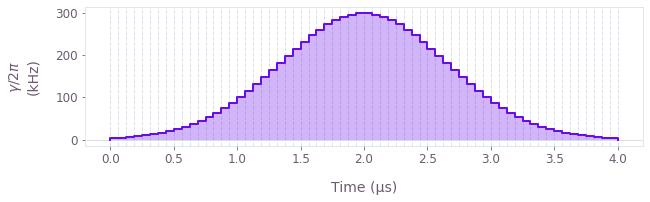

In [2]:
# Total gate duration.
gate_duration = 4e-6  # s
sigma = gate_duration / 6

times, dt = np.linspace(0, gate_duration, 64, retstep=True)
drive_values = np.exp(-((times - gate_duration / 2) ** 2) / 2 / sigma**2)
drive_values = np.pi * drive_values / np.sum(drive_values * dt)

# Visualize drive pulse.
qctrlvisualizer.plot_controls(
    {
        r"$\gamma$": {
            "values": drive_values,
            "durations": np.repeat(gate_duration / 64, 64),
        }
    }
)

#### Define the transmon

Create an object defining the transmon with the `boulderopal.superconducting.Transmon` class, passing to its constructor the number of dimensions in the system, as well as the coefficients of the different terms in the Hamiltonian.
Use the array of drive values to create a piecewise-constant `drive`.

In [3]:
# Physical properties of the transmon.
transmon_dimension = 4
alpha = 2 * np.pi * 0.45e6  # rad.Hz

# Create transmon object.
transmon = bo.superconducting.Transmon(
    dimension=transmon_dimension, anharmonicity=alpha, drive=drive_values
)

#### Define the initial state of the system

Create an array with the initial state of the transmon: its ground state.

In [4]:
# Initial state.
transmon_ground_state = np.zeros(transmon_dimension)
transmon_ground_state[0] = 1

### 3. Run the simulation

You now have objects that define the system that you want to simulate.
Use the `boulderopal.superconducting.simulate` function to obtain its dynamics, passing to it the system objects, as well as the duration of the simulation and the initial state of the system.

In [5]:
simulation_result = bo.superconducting.simulate(
    transmons=[transmon],
    cavities=[],
    interactions=[],
    gate_duration=gate_duration,
    initial_state=transmon_ground_state,
)

Your task (action_id="1828683") is queued.
Your task (action_id="1828683") has started.
Your task (action_id="1828683") has completed.


### 4. Extract the simulation outputs

After the calculation is complete, the results are stored in the output of the [returned dictionary](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting/optimize.html), `simulation_result`.
It contains the `"sample_times"` at which the dynamics are sampled, the `"unitaries"` defining the system's evolution, and the `"state_evolution"` of the initial state you provided.

#### Visualize the system dynamics

You can easily plot the dynamics of the system under the pulse with the `plot_population_dynamics` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package.


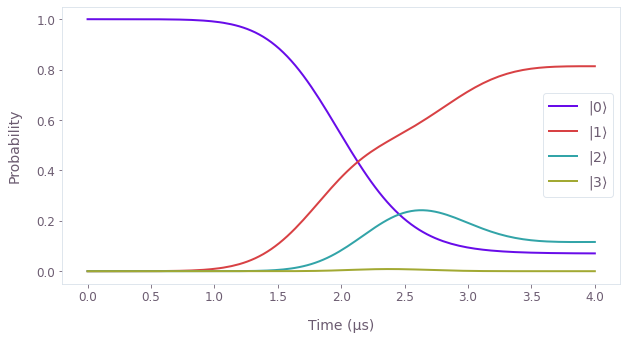

In [6]:
states = np.reshape(
    simulation_result["output"]["state_evolution"]["value"], [-1, transmon_dimension]
)
populations = np.abs(states) ** 2

qctrlvisualizer.plot_population_dynamics(
    simulation_result["output"]["sample_times"]["value"],
    {rf"$|{idx}\rangle$": populations[:, idx] for idx in range(transmon_dimension)},
)

You can see that the dynamics are far from what one would ideally expect (with the final state being $|1\rangle$), and leakage to higher excited transmon levels prevents a full transfer.

#### Compare implemented vs target gate

You can also see the failure of the dynamics by comparing the final implemented unitary (the last element in the `"unitaries"`) with the target gate $U_\mathrm{target}$ the pulse aims to implement (in the subspace of the two lowest transmon states).

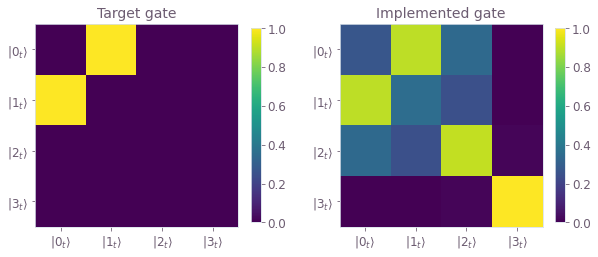

In [7]:
# Define the target gate and retrieve the implemented unitary.
target_operation = np.zeros([transmon_dimension, transmon_dimension])
target_operation[[0, 1], [1, 0]] = 1.0

implemented_operation = simulation_result["output"]["unitaries"]["value"][-1]


# Plot operators.
def plot_operator(ax, operator, title):
    image = ax.imshow(np.abs(operator), vmin=0, vmax=1)
    plt.colorbar(image, ax=ax, shrink=0.7)
    tick_labels = [rf"$|{t}_t\rangle$" for t in range(transmon_dimension)]
    ax.set_xticks(range(transmon_dimension), tick_labels)
    ax.set_yticks(range(transmon_dimension), tick_labels)
    ax.set_title(title)


fig, axs = plt.subplots(1, 2)
plot_operator(axs[0], target_operation, "Target gate")
plot_operator(axs[1], implemented_operation, "Implemented gate")

## Optimizing transmon-cavity dynamics

Your next task will be to optimize the dynamics of a transmon-cavity system aiming to achieve a target state propagation.

In a frame rotating with the transmon frequency, assuming that the transmon drive is resonant, and in the dispersive limit, the dynamics can be described by the following Hamiltonian:

$$
H_I = \frac{\alpha}{2} (b^\dagger)^2 b^2 + \Big(\gamma(t) b^\dagger + H.c.\Big) + \delta_C a^\dagger a + \Big( \Omega(t) a b^\dagger + H.c.\Big)  ,
$$

where
$b$ is the annihilation operator of the transmon system,
$a$ is the annihilation operator of a cavity excitation,
$\alpha$ is the transmon anharmonicity,
$\gamma(t)$ is a complex time-dependent drive applied to the transmon,
$\delta_C$ is the detuning between the drive frequency and the cavity transition frequency,
and $\Omega(t)$ is the Rabi coupling between the transmon and the cavity.

In this task, you will set up a drive $\gamma(t)$ and a coupling $\Omega(t)$ to drive the dynamics and achieve a target state propagation.
In particular, you want to take both systems starting in the ground state,

$$
|\psi_\mathrm{initial}\rangle = |0_t, 0_c\rangle  ,
$$

to a particular entangled state between the cavity and the transmon,

$$
|\psi_\mathrm{target}\rangle = \frac{1}{\sqrt{2}} \Big(|0_t, 0_c\rangle + i |1_t, 1_c\rangle \Big) .
$$

You will then simulate the system dynamics using the Boulder Opal superconducting module, and extract and visualize the resulting unitaries and system state dynamics to evaluate the gate performance.

### 1. Define the system

#### Define a cavity and an optimizable transmon

Similarly to what you did in the previous task, create objects representing the transmon and the cavity in the system with the `boulderopal.superconducting.Transmon` and `boulderopal.superconducting.Cavity` classes.

You can label a Hamiltonian coefficient as optimizable by using the [optimizable constant or signal classes](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting.html).
In this case, assign an optimizable drive for the transmon by passing a `boulderopal.superconducting.ComplexOptimizableSignal` to its `drive` attribute.

In [8]:
# Gate duration and number of optimizable piecewise-constant segments.
gate_duration = 5e-6  # s
segment_count = 20

# Physical properties of the transmon.
transmon_dimension = 5
alpha = 2 * np.pi * 0.3e6  # rad.Hz
gamma_max = 2 * np.pi * 0.3e6  # rad.Hz

# Create transmon object with optimizable drive.
transmon = bo.superconducting.Transmon(
    dimension=transmon_dimension,
    anharmonicity=alpha,
    drive=bo.superconducting.ComplexOptimizableSignal(segment_count, gamma_max),
)

# Physical properties of the cavity.
cavity_dimension = 4
K = 2 * np.pi * 4e5  # rad.Hz
delta = -2 * np.pi * 0.3e6  # rad.Hz

# Create cavity object.
cavity = bo.superconducting.Cavity(
    dimension=cavity_dimension, frequency=delta, kerr_coefficient=K
)

#### Define the transmon-cavity interaction

Define an optimizable Rabi coupling between the transmon and the cavity with a `boulderopal.superconducting.TransmonCavityInteraction` object.

In [9]:
# Physical properties of the interaction.
omega_max = 2 * np.pi * 0.2e6  # rad.Hz

# Create interaction object.
interaction = bo.superconducting.TransmonCavityInteraction(
    rabi_coupling=bo.superconducting.ComplexOptimizableSignal(segment_count, omega_max)
)

#### Define the initial and target states of the evolution

Define the initial state of the system (with both the transmon and the cavity in their ground state) and the target state $|\psi_\mathrm{target}\rangle$.

In [10]:
# Define initial state |00>.
transmon_ground_state = np.zeros(transmon_dimension)
transmon_ground_state[0] = 1
cavity_ground_state = np.zeros(cavity_dimension)
cavity_ground_state[0] = 1
initial_state = np.kron([transmon_ground_state], [cavity_ground_state])[0]

# Define target state (|00> + i |11>) / √2.
transmon_excited_state = np.zeros(transmon_dimension)
transmon_excited_state[1] = 1
cavity_excited_state = np.zeros(cavity_dimension)
cavity_excited_state[1] = 1
excited_state = np.kron([transmon_excited_state], [cavity_excited_state])[0]

target_state = (initial_state + 1j * excited_state) / np.sqrt(2)

### 2. Run the optimization

Similarly to how you've run the simulation above, use `boulderopal.superconducting.optimize` to obtain the optimized pulse, infidelity and system dynamics.
You also need to provide the target of the optimization, in this case, the `target_state`.
You can use the `cost_history_scope` parameter to request the evolution of the cost value during the optimization.

In [11]:
optimization_result = bo.superconducting.optimize(
    transmons=[transmon],
    cavities=[cavity],
    interactions=[interaction],
    gate_duration=gate_duration,
    initial_state=initial_state,
    target_state=target_state,
    cost_history_scope="ITERATION_VALUES",
)

Your task (action_id="1828690") is queued.
Your task (action_id="1828690") has started.
Your task (action_id="1828690") has completed.


### 3. Extract the optimization outputs

Similarly to the simulation, the results of the optimization are stored in the output of the [returned dictionary](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting/optimize.html), `optimization_result`.
Besides the `"sample_times"`, `"unitaries"`, and `"state_evolution"`, it also contains the optimized `"infidelity"` and the optimized values of the optimizable drives.

#### Retrieve the optimized infidelity

You can retrieve the optimized infidelity to assess the quality of the optimized pulses.

In [12]:
print(
    f"Optimized infidelity: {optimization_result['output']['infidelity']['value']:.3e}"
)

Optimized infidelity: 1.876e-06


#### Visualize the cost history

You can retrieve the evolution of the cost during the different optimizations from the optimized values dictionary, and plot them with the `plot_cost_histories` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package.

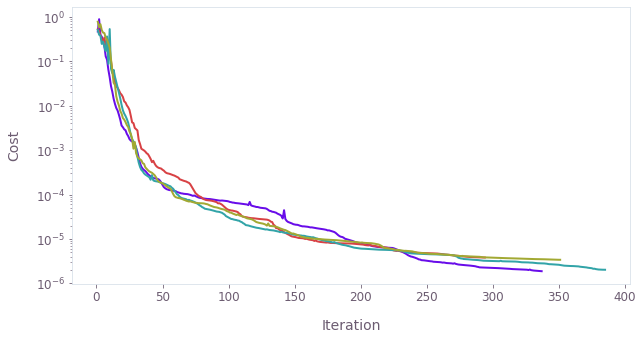

In [13]:
qctrlvisualizer.plot_cost_histories(
    optimization_result["cost_history"]["iteration_values"], y_axis_log=True
)

#### Visualize the optimized pulse

You can also retrieve the values of the optimized drive from the optimized values dictionary, and plot them with `plot_controls`.

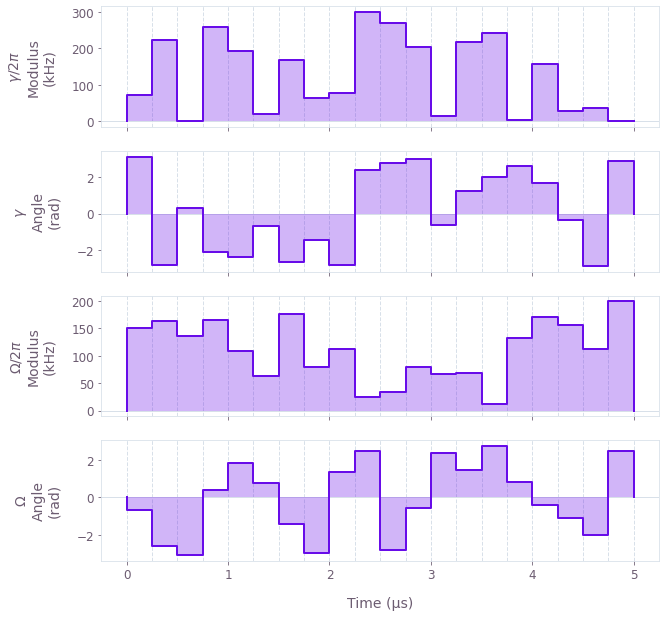

In [14]:
optimized_drive = optimization_result["output"]["transmon.drive"]
optimized_rabi_coupling = optimization_result["output"][
    "transmon_cavity_interaction.rabi_coupling"
]
qctrlvisualizer.plot_controls(
    {r"$\gamma$": optimized_drive, r"$\Omega$": optimized_rabi_coupling}
)

#### Visualize the system dynamics

You can plot the optimized dynamics similarly to how you plotted the simulation results earlier.

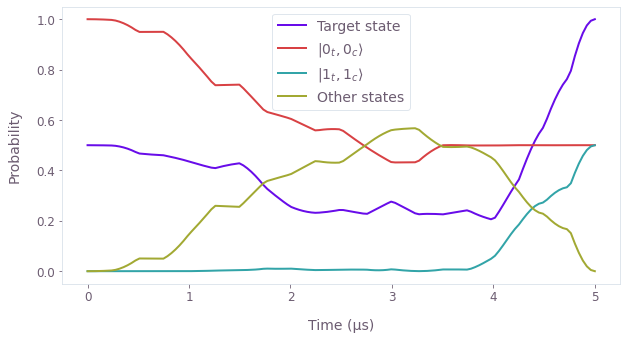

In [15]:
state_evolution = optimization_result["output"]["state_evolution"]["value"]
states = np.reshape(state_evolution, [-1, transmon_dimension, cavity_dimension])

population_target = np.abs(state_evolution @ np.conj(target_state)) ** 2

population_00 = np.abs(states[:, 0, 0]) ** 2
population_11 = np.abs(states[:, 1, 1]) ** 2
population_others = 1 - population_00 - population_11 - population_target

qctrlvisualizer.plot_population_dynamics(
    optimization_result["output"]["sample_times"]["value"],
    {
        "Target state": population_target,
        r"$|0_t, 0_c\rangle$": population_00,
        r"$|1_t, 1_c\rangle$": population_11,
        "Other states": 1 - population_00 - population_11,
    },
)

You can see that, although the dynamics populate other states during the evolution, the final state corresponds to the target entangled state, with an equal superposition of states $|0_t, 0_c\rangle$ and $|1_t, 1_c\rangle$.

This concludes this tutorial.
Congratulations on making it this far!

You can extend the calculations you have done here by adding more transmons or cavities to the system, or with different terms/interactions in the system's Hamiltonian.
You can find information on the terms available for the different subsystems and their interactions in the [reference of the superconducting classes](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting.html).

The functions you've just used to [simulate](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting/simulate.html) and [optimize](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting/optimize.html) have more options, such as creating filtered (smooth) pulses through a `cutoff_frequency` parameter, or optimizing target operations instead of state-to-state dynamics.
Take a look at [their reference](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/superconducting.html) to learn more.
You can visit our [topics page](https://docs.q-ctrl.com/boulder-opal/topics) to learn more about Boulder Opal and its capabilities.